In [1]:
# Initial imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from pathlib import Path
import requests

%matplotlib inline

In [2]:
RTX_csv = Path("../ASD_Data/RTX_DATA.csv")

In [3]:
RTX_df = pd.read_csv(RTX_csv, index_col='Date', infer_datetime_format=True, parse_dates=True)

In [4]:
RTX_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-06-30,54.568913,56.419132,54.518566,55.701698,43.800762,7308606
2011-07-01,55.833858,56.972939,55.607300,56.721207,44.602436,7124599
2011-07-05,56.551289,56.998112,56.148521,56.331024,44.295628,6430524
2011-07-06,56.406544,57.023285,56.230335,56.903713,44.745949,6882754
2011-07-07,57.275017,57.791065,57.117683,57.514160,45.225967,10032469


In [5]:
RTX_df.sort_index(ascending=True, inplace=True)

In [6]:
RTX_df = RTX_df.rename(columns={'Close': 'Close'})
RTX_df = RTX_df[['Close']]
RTX_df

,Close
Date,
2011-06-30,55.701698
2011-07-01,56.721207
2011-07-05,56.331024
2011-07-06,56.903713
2011-07-07,57.514160
...,...
2021-06-24,86.849998
2021-06-25,86.720001
2021-06-28,85.110001


In [7]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window-1):
        features = df.iloc[i : (i+window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [8]:
window_size = 100
feature_column = 0
target_column = 0

X, y = window_data(RTX_df, window_size, feature_column, target_column)

print(f"X sample values:\n{X[:3]} \n")
print(f"y sample values:\n{y[:3]}")

X sample values:
[[55.701698 56.721207 56.331024 56.903713 57.51416  56.859661 56.091881
  55.670235 55.487728 55.267464 55.582127 55.141598 55.89679  54.88987
  55.512901 55.191944 54.952801 54.235367 52.69981  52.183762 52.133415
  51.818752 49.672749 49.911896 46.80302  46.658276 43.88924  45.040905
  42.441788 43.88924  45.594715 46.280682 45.657646 45.342983 42.869728
  42.448082 42.592827 44.008812 44.940212 44.524857 45.034615 46.488358
  46.419132 46.727501 45.972309 44.707363 44.367527 45.915668 45.707993
  44.386406 44.764004 45.594715 46.368786 47.583385 47.51416  47.545628
  47.835117 47.117683 42.9893   43.373192 45.02832  46.03524  45.217117
  45.575832 44.279423 43.650093 43.763374 43.807426 44.669605 44.97168
  46.412838 46.406544 46.721207 46.280682 46.972939 45.387035 46.645687
  46.104469 46.727501 47.551918 48.237885 47.37571  47.866585 49.905602
  50.037762 49.07489  47.319069 48.401508 49.36438  48.961613 49.301449
  49.634991 48.105728 48.753933 50.239143 49.7482

In [9]:
split = int(0.6 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [10]:
y_train

array([[46.614223],
       [45.972309],
       [44.663311],
       ...,
       [72.806793],
       [73.650093],
       [72.561356]])

In [11]:
# Import MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

x_train_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()

x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

X_test = x_train_scaler.transform(X_test)
y_test = y_train_scaler.transform(y_test)

In [12]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [14]:
model = Sequential()

number_units = window_size
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units = number_units,
    return_sequences = True,
    input_shape= (X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(
    units = number_units,
    return_sequences = True
    ))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(
    units = number_units
    ))
model.add(Dropout(dropout_fraction))

# Output Layer
model.add(Dense(1))

In [15]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 100)          40800     
_________________________________________________________________
dropout (Dropout)            (None, 100, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 100)          80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [16]:
model.fit(X_train, y_train, epochs=20, shuffle=False, batch_size=100, verbose=1)

Epoch 1/20
15/15 [==============================] - 54s 1s/step - loss: 0.0210
Epoch 2/20
15/15 [==============================] - 15s 1s/step - loss: 0.0133
Epoch 3/20
15/15 [==============================] - 14s 935ms/step - loss: 0.0087
Epoch 4/20
15/15 [==============================] - 16s 1s/step - loss: 0.0081
Epoch 5/20
15/15 [==============================] - 14s 925ms/step - loss: 0.0054
Epoch 6/20
15/15 [==============================] - 14s 903ms/step - loss: 0.0064
Epoch 7/20
15/15 [==============================] - 13s 873ms/step - loss: 0.0051
Epoch 8/20
15/15 [==============================] - 14s 939ms/step - loss: 0.0083
Epoch 9/20
15/15 [==============================] - 14s 903ms/step - loss: 0.0098
Epoch 10/20
15/15 [==============================] - 14s 920ms/step - loss: 0.0066
Epoch 11/20
15/15 [==============================] - 14s 905ms/step - loss: 0.0049
Epoch 12/20
15/15 [==============================] - 14s 941ms/step - loss: 0.0047
Epoch 13/20
15/15 [===

In [17]:
model.evaluate(X_test, y_test, verbose=0)

0.011059409938752651

In [18]:
predicted = model.predict(X_test)

In [19]:
predicted_prices = y_train_scaler.inverse_transform(predicted)

In [20]:
real_prices = y_train_scaler.inverse_transform(y_test.reshape(-1,1))

In [21]:
RTX_actual_predicted = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = RTX_df.index[-len(real_prices): ])

RTX_actual_predicted.head()

,Actual,Predicted
Date,,
2017-08-28,72.416611,73.620537
2017-08-29,72.580238,73.510628
2017-08-30,74.701073,73.407761
2017-08-31,75.267464,73.371849
2017-09-01,75.342979,73.425941


In [22]:
RTX_actual_predicted.tail()

,Actual,Predicted
Date,,
2021-06-24,86.599998,85.977493
2021-06-25,86.849998,85.822861
2021-06-28,86.720001,85.667328
2021-06-29,85.110001,85.516769
2021-06-30,84.440002,85.334427


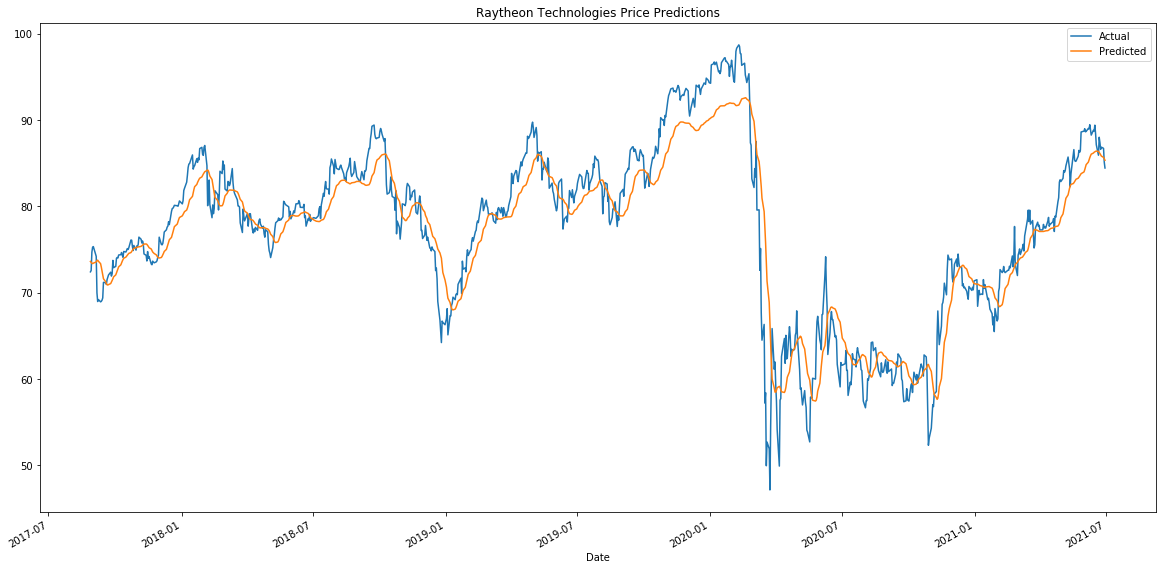

In [29]:
RTX_actual_predicted.plot(figsize=(20,10), title="Raytheon Technologies Price Predictions")